In [4]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
import os
import numpy as np
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.reset()
# Fashion - MNIST - https://github.com/zalandoresearch/fashion-mnist
mnist = keras.datasets.mnist
fashion_mnist = keras.datasets.fashion_mnist
cifar10 = keras.datasets.cifar10
#(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
#(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
#train_images = train_images.reshape((60000,  28, 28,1))
#test_images = test_images.reshape((10000,28,28,1))

train_images = train_images.reshape((50000,32, 32,3))
test_images = test_images.reshape((10000,32,32,3))

# # import scipy.ndimage as ndi
# # train_images_z = ndi.zoom(train_images, (1, 512/28.0, 512/28.0, 1), order=2)

# # normalize inputs from 0-255 to 0.0-1.0
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
train_images_norm = train_images / 255.0
test_images_norm = test_images / 255.0

# for tn in train_images_norm:
#     print(tn.shape)

# train_images=np.pad(train_images, ((0,0), (114,114), (114, 114)), 'constant')/255.0
# test_images=np.pad(test_images, ((0,0), (114,114), (114, 114)), 'constant')/255.0
# train_images_norm = train_images.reshape((60000,  256, 256,1))
# test_images_norm = test_images.reshape((10000,256,256,1))


#pad with zeros now
#paddings = tf.constant([ [0,0], [114,114], [114,114], [0,0]             ]     )
#train_images_norm = tf.pad(train_images_norm, paddings, "CONSTANT")



def grayscale(data, dtype='float32'):
    # luma coding weighted average in video systems
    r, g, b = np.asarray(.3, dtype=dtype), np.asarray(.59, dtype=dtype), np.asarray(.11, dtype=dtype)
    rst = r * data[:, :, :, 0] + g * data[:, :, :, 1] + b * data[:, :, :, 2]
    # add channel dimension
    rst = np.expand_dims(rst, axis=3)
    return rst


train_images_norm = grayscale(train_images_norm)
test_images_norm = grayscale(test_images_norm)


In [14]:
chc = np.random.randint(0,10000,10)
fig, ax = plt.subplots(1,10, figsize=(8,0.8))
#ax[0][0].imshow(   np.squeeze(train_images_norm[0]), cmap='Greys_r')
for idx, ch in enumerate(chc):
    #print(idx//5, idx%5)
    ax[idx%10].imshow(    np.squeeze(train_images_norm[ch]),cmap='Greys_r')
    ax[idx%10].set_xticks([])
    ax[idx%10].set_yticks([])
plt.tight_layout()
#plt.xticks([])
#plt.show()
plt.savefig('mnist.pdf', dpi=1600, pad_inches=0)

In [7]:
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, Activation, BatchNormalization
from keras.layers import Dropout, UpSampling2D, ZeroPadding2D
from keras.layers import Flatten, Cropping1D
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.engine.topology import Layer
from keras.layers import Lambda, Input
import tensorflow as tf


    
class Hadamard(Layer):

    def __init__(self, **kwargs):
        #self.output_dim = output_dim
        #super(MyLayer, self).__init__(**kwargs)
        super(Hadamard, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel', 
                                      #shape=(input_shape[1], self.output_dim),
                                      shape=(1,) + input_shape[1:],
                                      initializer='uniform',                                      
                                      trainable=True)
        super(Hadamard, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x):
        #print(x.shape, self.kernel.shape)
        return x * tf.exp(2.0*np.pi*1j*tf.keras.backend.cast(self.kernel, dtype='complex64')           )

    def compute_output_shape(self, input_shape):
        #print(input_shape)
        return input_shape

    




class NHadamard(Layer):

    def __init__(self, **kwargs):
        #self.output_dim = output_dim
        #super(MyLayer, self).__init__(**kwargs)
        super(NHadamard, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel', 
                                      #shape=(input_shape[1], self.output_dim),
                                      shape=(1,) + input_shape[1:],
                                      initializer='uniform',                                      
                                      trainable=True)
        super(NHadamard, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x):
        #print(x.shape, self.kernel.shape)
        linpart =  x * tf.exp(2.0*np.pi*1j*tf.keras.backend.cast(self.kernel, dtype='complex64')           )
        xsq = tf.math.abs(x)**2
        Ifull = 2
        return linpart*tf.exp(2.0*np.pi*1j*tf.keras.backend.cast(xsq/Ifull, dtype='complex64'))

    def compute_output_shape(self, input_shape):
        #print(input_shape)
        return input_shape   
    
    


def propagate(x):
    N = 256
    d = 40 # plate spacing
    lam = 1    # wavelength 
    P = 0.5  # pitch of metasurface
    df = 1.0/(N*P)
    k = np.pi*2.0/lam
    

    def phase(i,j):
        i -= N//2
        j -= N//2
        return ((i*df)*(i*df)+(j*df)*(j*df))
    ph  = np.fromfunction(phase,shape=(N,N),dtype=np.float32)
#     H = np.expand_dims(np.fft.fftshift(np.exp(1.0j*k*d)*np.exp(-1.0j*lam*np.pi*d*ph)), axis=2)
    H = np.fft.fftshift(np.exp(1.0j*k*d)*np.exp(-1.0j*lam*np.pi*d*ph))
    
    x = tf.squeeze(x, axis=3)
    x2 = (tf.keras.backend.cast(x, dtype='complex64'))
    Fx = tf.fft2d(x2)*H
    
    out = tf.ifft2d(Fx)
    return tf.expand_dims(out, axis=3)

def oeconvert(x):
    return np.abs(x)**2

# photodetector pooling layer and o/E conversion
def pdpooler(x):
    x2 = (tf.math.abs(x)**2)
    N = 256
    boxes=[[ 51, 102,  51, 102], #0
    [103, 154,  51, 102],  #1
    [155, 206,  51, 102],   #2
    [ 24,  75, 103, 154],   #3
    [ 76, 127, 103, 154],   #4
    [128, 179, 103, 154],   #5
    [180, 231, 103, 154],   #6
    [ 51, 102, 155, 206],    #7
    [103, 154, 155, 206],   #8
    [155, 206, 155, 206]]   #9
 
        
#     boxes=[[120, 170, 120, 170], #0
#     [120, 170, 240, 290],  #1
#     [120, 170, 360, 410],   #2
#     [220, 270, 120, 170],   #3
#     [220, 270, 200, 250],   #4
#     [220, 270, 280, 330],   #5
#     [220, 270, 360, 410],   #6
#     [320, 370, 120, 170],    #7
#     [320, 370, 240, 290],   #8
#     [320, 370, 360, 410]]   #9
    
    
    #region = tf.math.reduce_max(x[:,3:5,3:5,:], axis=[1,2])
    region = tf.stack([ 0.2*tf.squeeze(tf.math.reduce_sum(x2[:, b[0]:b[1], b[2]:b[3],:], axis=[1,2]), axis=1)  for b in boxes])
    #region = tf.stack([ 0.001  for b in boxes], axis=1)
    #reg = tf.stack( [ np.amax(x2[:, 3:5, 3:5,:], axis=[1,2])  for b in boxes], axis=1)
    
    return tf.transpose(region)

class Corr4f(Layer):

    def __init__(self, **kwargs):
        #self.output_dim = output_dim
        #super(MyLayer, self).__init__(**kwargs)
        super(Corr4f, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel', 
                                      #shape=(input_shape[1], self.output_dim),
                                      shape=(1,) + input_shape[1:],
                                      initializer='uniform',                                      
                                      trainable=True)
        super(Corr4f, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x):
        #print(x.shape, self.kernel.shape)
        x3 = tf.squeeze(x, axis=3)
        x2 = (tf.keras.backend.cast(x3, dtype='complex64'))
        Fx = tf.fft2d(x2)
        plate = Fx * tf.squeeze(tf.exp(2.0*np.pi*1j*tf.keras.backend.cast(self.kernel, dtype='complex64') ), axis=3)
        out = tf.expand_dims(tf.ifft2d(plate), axis =3)
        xsq = tf.math.abs(out)**2
        Ifull = 2
        out = out*tf.exp(2.0*np.pi*1j*tf.keras.backend.cast(xsq/Ifull, dtype='complex64'))
        return out

    def compute_output_shape(self, input_shape):
        #print(input_shape)
        return input_shape

def satabs(x):
    #print(x.shape, self.kernel.shape)
    S = 0.1
    #fac = 1.0/(1.0 - S)
    x = tf.keras.backend.cast(x, dtype='complex64')
    il = tf.math.abs(x*x)
    iout = 0.5*(tf.math.abs(il - S) + il - S + 0.0000001    )
    ampo = tf.math.sqrt(iout)
    angpart = tf.exp(1j*tf.keras.backend.cast( tf.math.angle(x), dtype='complex64')               )
    xo = angpart*tf.keras.backend.cast(ampo, dtype='complex64')
    return xo

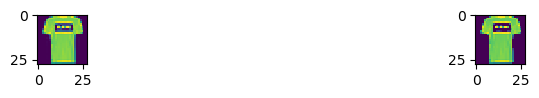

In [16]:
#plt.figure(figsize=(3,3))
ims = train_images_norm[0:3]
with tf.Session() as sess:
    imsn = satabs(ims).eval()

plt.subplot(121)
plt.imshow( np.squeeze(     np.abs( ims[1]) ) )
plt.subplot(122)
plt.imshow( np.squeeze(     np.abs( imsn[1]) ) )


plt.show()


In [9]:
iput = Input(shape=(32,32,1))
upsamp = UpSampling2D(size=2)(iput)
padded = ZeroPadding2D(padding=96)(upsamp)
# #padded2 = ZeroPadding2D(padding=50)(padded)
# #cast_iput = tf.keras.backend.cast(iput,  dtype='complex64') 

corr1 = Corr4f()(padded)
#nl1 = Lambda(satabs)(corr1)
# #corr2 = Corr4f()(corr1)


# # # hada2=Hadamard()(prop2)
prop1 = Lambda(propagate)(corr1)
hada1=Hadamard()(prop1)
nsat = Lambda(satabs)(hada1)
prop2 = Lambda(propagate)(nsat)

# #corr2 = Corr4f()(prop2)


# hada4=Hadamard()(prop4)
#prop3 = Lambda(propagate)(corr2)
# hada5=Hadamard()(prop5)
# prop6 = Lambda(propagate)(hada5)
pdo = Lambda(pdpooler)(prop2)
#pdo = Lambda(oeconvert)(prop2)
#mpool = AveragePooling2D(strides=(32,32))(pdo)
#fc = Flatten()(mpool)
#bn = BatchNormalization()(pdo)
#fc2 = Dense(10, activation='relu')(bn)
#mpool = AveragePooling2D(strides=(10,10))(pdo)
#fc = Flatten()(mpool)
#oput = Dense(10, activation='softmax')(fc2)
oput = Activation('softmax')(pdo)

model_f = Model(inputs=iput, outputs=oput)

model_f.summary()

model_f.compile(optimizer='nadam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
hstry3 = model_f.fit(train_images_norm, train_labels, epochs=60, batch_size=128, shuffle=True,
           validation_data=(test_images_norm, test_labels))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 64, 64, 1)         0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 256, 256, 1)       0         
_________________________________________________________________
corr4f_2 (Corr4f)            (None, 256, 256, 1)       65536     
_________________________________________________________________
lambda_5 (Lambda)            (None, 256, 256, 1)       0         
_________________________________________________________________
hadamard_2 (Hadamard)        (None, 256, 256, 1)       65536     
_________________________________________________________________
lambda_6 (Lambda)            (None, 256, 256, 1)       0         
__________

50000/50000 [==============================] - 54s 1ms/step - loss: 1.7441 - acc: 0.4072 - val_loss: 1.7965 - val_acc: 0.3827
Epoch 47/60
50000/50000 [==============================] - 54s 1ms/step - loss: 1.7435 - acc: 0.4067 - val_loss: 1.7937 - val_acc: 0.3815
Epoch 48/60
50000/50000 [==============================] - 54s 1ms/step - loss: 1.7420 - acc: 0.4075 - val_loss: 1.7876 - val_acc: 0.3882
Epoch 49/60
50000/50000 [==============================] - 54s 1ms/step - loss: 1.7415 - acc: 0.4072 - val_loss: 1.7853 - val_acc: 0.3873
Epoch 50/60
50000/50000 [==============================] - 54s 1ms/step - loss: 1.7405 - acc: 0.4089 - val_loss: 1.7852 - val_acc: 0.3843
Epoch 51/60
50000/50000 [==============================] - 54s 1ms/step - loss: 1.7392 - acc: 0.4071 - val_loss: 1.7892 - val_acc: 0.3858
Epoch 52/60
50000/50000 [==============================] - 54s 1ms/step - loss: 1.7390 - acc: 0.4080 - val_loss: 1.7911 - val_acc: 0.3831
Epoch 53/60
50000/50000 [=====================

In [10]:
model_cnv = Model(inputs=iput, outputs=corr1)
model_prop = Model(inputs=iput, outputs=nsat)
convo = np.abs(model_cnv.predict(test_images_norm))**2
pdinp = np.abs(model_prop.predict(test_images_norm))**2
pdsig = np.abs(model_f.predict(test_images_norm))
preds = np.argmax(model_f.predict(test_images_norm), axis=1)

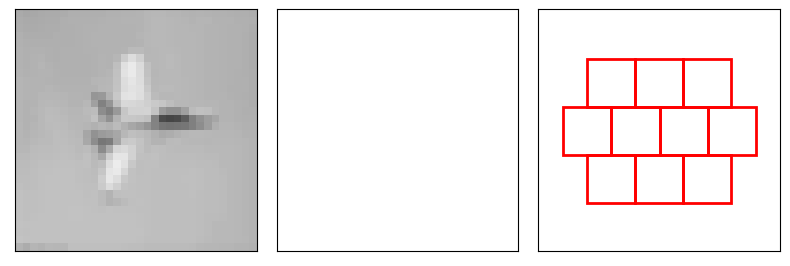

0 T-shirt/top [0]
[nan nan nan nan nan nan nan nan nan nan]


In [130]:

import matplotlib.patches as patches
fig, ax = plt.subplots(1,3,figsize=(8,3))
idx = np.random.randint(10000)
#plt.subplot(121)
ax[0].imshow(np.squeeze(test_images_norm[idx]), cmap='Greys_r', vmin=0, vmax=1)
ax[0].set_xticks(ticks=[])
ax[0].set_yticks(ticks=[])
ax[1].imshow(np.squeeze(np.squeeze(convo[idx])), cmap='Greys_r', vmin=0, vmax=1)
ax[1].set_xticks(ticks=[])
ax[1].set_yticks(ticks=[])
# ax[2].imshow(np.squeeze(np.squeeze(prop2d[idx])), cmap='Greys_r', vmin=0, vmax=1)
# ax[2].set_xticks(ticks=[])
# ax[2].set_yticks(ticks=[])




#plt.subplot(122)
#ax[1].imshow(np.squeeze(test_images_norm[idx]), cmap='Greys_r', vmin=0, vmax=1)
plt.imshow(np.transpose(np.squeeze(pdinp[idx])), vmin=0, vmax=1, cmap='Greys_r')
#ax[1].imshow(np.squeeze(test_images_norm[idx]), cmap='Greys_r', vmin=-5, vmax=5)
rect1 = patches.Rectangle((128 - 51,103),51,51,linewidth=2,edgecolor='r',facecolor='none')
ax[2].add_patch(rect1)
rect2 = patches.Rectangle((128 - 102,103),51,51,linewidth=2,edgecolor='r',facecolor='none')
ax[2].add_patch(rect2)
rect3 = patches.Rectangle((128 ,103),51,51,linewidth=2,edgecolor='r',facecolor='none')
ax[2].add_patch(rect3)
rect4 = patches.Rectangle((128+ 51, 103),51,51,linewidth=2,edgecolor='r',facecolor='none')
ax[2].add_patch(rect4)
rect5 = patches.Rectangle((128 - 51+25,128+ 26),51,51,linewidth=2,edgecolor='r',facecolor='none')
ax[2].add_patch(rect5)
rect6 = patches.Rectangle((128 - 102+25,128 + 26),51,51,linewidth=2,edgecolor='r',facecolor='none')
ax[2].add_patch(rect6)
rect7 = patches.Rectangle((128+25 ,128 + 26),51,51,linewidth=2,edgecolor='r',facecolor='none')
ax[2].add_patch(rect7)
rect8 = patches.Rectangle((128 - 51+25,128- 51-25),51,51,linewidth=2,edgecolor='r',facecolor='none')
ax[2].add_patch(rect8)
rect9 = patches.Rectangle((128 - 102+25,128 - 51-25),51,51,linewidth=2,edgecolor='r',facecolor='none')
ax[2].add_patch(rect9)
rect10 = patches.Rectangle((128+25 ,128 - 51-25),51,51,linewidth=2,edgecolor='r',facecolor='none')
ax[2].add_patch(rect10)
ax[2].set_xticks(ticks=[])
ax[2].set_yticks(ticks=[])
plt.tight_layout()
#plt.colorbar()
plt.show()
print(preds[idx], class_names[preds[idx]], test_labels[idx])
print(pdsig[idx])
#plt.savefig('imflow.pdf', dpi=1600, pad_inches=0)

In [ ]:
plt.imshow( np.squeeze(  np.abs(pdinp[idx])))
plt.show()

In [ ]:
import sklearn.metrics as met
fig, ax = plt.subplots(figsize=(2,2))
cm = met.confusion_matrix(test_labels, preds, normalize='all')
i=ax.imshow(cm, cmap='Purples')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.yticks( ticks=[] ) #[0,1,2,3,4,5,6,7,8,9]  )
plt.xticks( ticks=[0,1,2,3,4,5,6,7,8,9]  )
#plt.ylim([-0.5,9.5])
cbar = fig.colorbar(i)
cbar.set_ticks([])
plt.tight_layout()
plt.show()

In [ ]:
def propagate(x):
    N = 28
    d = 120 # plate spacing
    lam = 1    # wavelength 
    P = 0.5  # pitch of metasurface
    df = 1.0/(N*P)
    k = np.pi*2.0/lam
    print("here")

    def phase(i,j):
        i -= N//2
        j -= N//2
        return ((i*df)*(i*df)+(j*df)*(j*df))
    ph  = np.fromfunction(phase,shape=(N,N),dtype=np.float32)
#     H = np.expand_dims(np.fft.fftshift(np.exp(1.0j*k*d)*np.exp(-1.0j*lam*np.pi*d*ph)), axis=2)
    H = np.fft.fftshift(np.exp(1.0j*k*d)*np.exp(-1.0j*lam*np.pi*d*ph))
    
    
    x2 = tf.squeeze(tf.keras.backend.cast(x, dtype='complex64'))
    Fx = tf.fft2d(x2)*H
    
    out = tf.ifft2d(Fx)
    return out

def propagate_np(x):
    N = 28
    d = 120 # plate spacing
    lam = 1    # wavelength 
    P = 0.5  # pitch of metasurface
    df = 1.0/(N*P)
    k = np.pi*2.0/lam
    def phase(i,j):
        i -= N//2
        j -= N//2
        return ((i*df)*(i*df)+(j*df)*(j*df))
    ph  = np.fromfunction(phase,shape=(N,N),dtype=np.float32)
    H = np.fft.fftshift(np.exp(1.0j*k*d)*np.exp(-1.0j*lam*np.pi*d*ph)) 
    print(H.shape)
    Fx = H*(np.fft.fft2(np.squeeze(x)))
    return np.fft.ifft2(Fx)





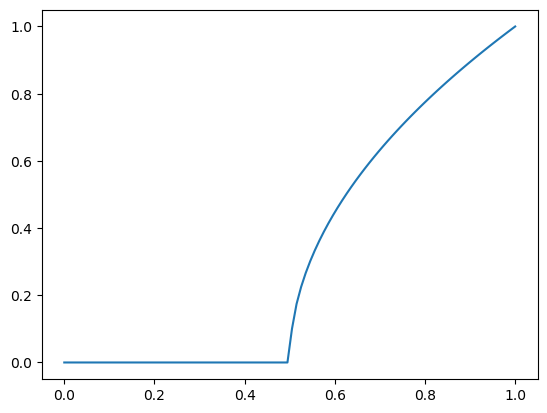

In [116]:
def shftrelu(x, S):
    fac = 1/(1.0 - S)
    io = fac*0.5*(np.abs(x - S) + x - S)
    return np.sqrt(io)

a = np.linspace(0, 1, 100)
io = shftrelu(a, 0.5)
plt.plot(a, io)
plt.show()

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.0010101 , 0.01111111, 0.02121212, 0.03131313, 0.04141414,
       0.05151515, 0.06161616, 0.07171717, 0.08181818, 0.09191919,
       0.1020202 , 0.11212121, 0.12222222, 0.13232323, 0.14242424,
       0.15252525, 0.16262626, 0.17272727, 0.18282828, 0.19292929,
       0.2030303 , 0.21313131, 0.22323232, 0.23333333, 0.24343434,
       0.25353535, 0.26363636, 0.27373737, 0.28383838, 0.29393939,
       0.3040404 , 0.31414141, 0.32424242, 0.33434343, 0.34444444,
       0.35454545, 0.36464646, 0.37474747, 0.38484848, 0.39494949,
       0.40505051, 0.41515152, 0.42525253, 0.43535354, 0.44545455,
       0.45555556, 0.46565657, 0.47575758, 0.48585859, 0.4959596 ,
       0.50606061, 0.51616162, 0.52626263, 0.53636364, 0.54646465,
       0.55656566, 0.56666667, 0.57676768, 0.58686869, 0.5969697 ,
       0.60707071, 0.61717172, 0.62727273, 0.63737374, 0.64747

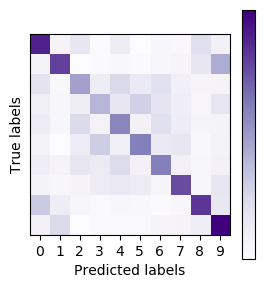

In [11]:
preds = np.argmax(model_f.predict(test_images_norm), axis=1)
import sklearn.metrics as met
fig, ax = plt.subplots(figsize=(3,3))
cm = met.confusion_matrix(test_labels, preds, normalize='all')
i=ax.imshow(cm, cmap='Purples')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.yticks( ticks=[] ) #[0,1,2,3,4,5,6,7,8,9]  )
plt.xticks( ticks=[0,1,2,3,4,5,6,7,8,9]  )
#plt.ylim([-0.5,9.5])
cbar = fig.colorbar(i)
cbar.set_ticks([])
plt.tight_layout()
plt.show()